In [329]:
%pdb off
%matplotlib inline

import os, os.path as op
import socket, glob
from pathlib import Path
import xarray as xr
from datetime import datetime
# from VLM import *

from IPython.display import Image, display
from mintpy.cli import view, tsview
from mintpy.utils import writefile, readfile, utils as ut


Automatic pdb calling has been turned OFF


In [330]:
track    = 91
mp_exp0  = 'ERA5_PM_MG_ex' # determines corrections applied
print (os.getenv('CONDA_PROMPT_MODIFIER'), datetime.now())
print ('Track:', track)

(ARIA)  2023-09-28 16:00:22.725802
Track: 91


In [213]:
# track 62 has non fast

### Helpers

In [331]:
def combine_masks(lst_path_masks, apply_osm=False, mask_all=True, show=False):
    """ Used to combine multiple custom Vup masks / temporal coherence

    If mask all, pixel is masked if masked in any mask. (FRInGE)
    Else, if pixel is not masked in any, keeps it. (ARIA)
    """
    from mintpy.utils import readfile, writefile
    import h5py, shutil, xarray as xr
    lst_masks = []
    for mask in lst_path_masks:
        arr, meta = readfile.read(mask)
        lst_masks.append(arr)


    ## reapply the watermask to account for some geocoding error
    if apply_osm:
        # open the netcdf watermask for the correct size/shape
        da0 = xr.open_dataset(op.join(Exp.path_mp, 'geo_waterMask.nc'))['Band1']
        # open the full watermask
        path_osm = op.join(Exp.path_crops, 'OSM_wmask.tif')
        da = xr.open_dataset(path_osm)['band_data'].squeeze().rename(x='lon', y='lat')

        # crop the full mask
        S, N, W, E = da0.lat.min(), da0.lat.max(), da0.lon.min(), da0.lon.max()
        da_crop    = da.sel(lat=slice(N, S), lon=slice(W, E))
        da_crop    = da_crop.where(~np.isclose(da_crop, 0), np.nan)
        da_mask1   = da_crop.interp_like(da0)
        da_mask1   = da_mask1.where(~np.isnan(da_mask1), 0)
        lst_masks.append(np.flipud(da_mask1.data))

    print ('Using', len(lst_masks), 'masks')

    mask = np.stack(lst_masks)
    if mask_all:
        mask = mask.prod(0, dtype=bool)
    else:
        mask = mask.sum(0, dtype=bool)

    # copy any mask h5 to where to write; use stitched if stitch in any of the masks
    stitch = True if any(['stitch' in str(p) for p in lst_path_masks]) else False

    # hardcoding mask type for now
    dst = lst_path_masks[0].parent / 'maskWaterTempCoh.h5'
    dst = shutil.copy(lst_path_masks[0], dst)

    try:
        writefile.write_hdf5_block(dst, mask, 'waterMask')
    except:
        writefile.write_hdf5_block(dst, mask, 'mask')

    print ('Wrote combined mask to:', dst)

    if show:
        from mintpy.cli import view
        cmd = f'{dst} --noverbose -c binary'
        obj = view.main(cmd.split())

    return dst

In [332]:
# track to GPS station, its lalo
dct_gps  = {33: ['NYBK', '40.703432 -73.978965'], 
            135: ['CTWF', '41.3358099728 -72.1155494566'], #['URIL', '41.4889420 -71.5277192'], 
            62: ['MAMI', '42.2720614 -71.0486846'], 
            164: ['MERO', '44.1137947 -69.1186410'], 
            # 91: ['HAL3', '44.6572781589 -63.6650616709'],
            91: ['GEO2', '45.127810 -66.808729'],
            106: ['FTML', '39.876033 -75.210490'], # Philly
}


# track to region name
dct_reg  = {33: 'NYC', 135: 'RI', 62: 'Mass', 164: 'Maine', 91: 'NS', 106: 'DE'}

## Setup Parameters

In [333]:
reg      = dct_reg[track]
ref_sta  = dct_gps[track][0]
mp_exp   = f'{ref_sta}_{mp_exp0}'

path_wd    = Path(os.getenv('dataroot')) / 'VLM' / 'Sentinel1' / 'EastCoast' / f'track_{str(track).zfill(3)}'
path_wd_mp = path_wd / mp_exp
path_wd_mp.mkdir(exist_ok=True)
os.chdir(path_wd_mp)


print (f'\n{reg} Experiment:', mp_exp)
print ('MintPy Directory:', str(path_wd_mp))


NS Experiment: GEO2_ERA5_PM_MG_ex
MintPy Directory: /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex


In [334]:
# initial parameters for determining network
dct_coh   = {33: [0.4, 0.7]} # spatial, temporal
min_scoh  = dct_coh.get(track, 0.45)
min_tcoh  = dct_coh.get(track, 0.2)
boots     = 0
wgt_fn    = 'var' if not 'Fast' in mp_exp else 'no' # var significantly improves tcoh
write_cfg = True
fs, ls    = (10, 10), 10

In [335]:
if 'gacos' in mp_exp.lower():
    ATM = 'gacos'
elif 'pyaps' in mp_exp.lower() or 'era' in mp_exp.lower():
    ATM = 'pyaps'
else:
    ATM = 'no'

if 'unwc' in mp_exp.lower():
    UNW = 'bridging+phase_closure'
elif 'bridging' in mp_exp.lower():
    UNW = 'bridging'
elif 'closure' in mp_exp.lower():
    UNW = 'phase_closure'
else:
    UNW = 'no'

# rms = 1.645 if 'ex' in mp_exp else 1e6 # rms threshold 90% conf interval
rms = 2 if 'ex' in mp_exp else 1e6 # rms threshold 95% conf interval

SET = 'yes' if 'set' in mp_exp.lower() else 'no'

TSM      = 'bootstrap' if boots > 0 else 'residue'

PERIODIC = '1,0.5' if TSM == 'residue' else 'auto' # can't bootstrap periodic fit
print ('Experiment:', mp_exp)

Experiment: GEO2_ERA5_PM_MG_ex


In [336]:
## set marin parameters
if '_mg' in mp_exp.lower():
    CONNMAX  = 4
    min_scoh = 0.0
    minRedun = 0
else:
    CONNMAX  = 'no'
    minRedun = 1

In [337]:
path_ifgs  = path_wd_mp / 'inputs' / 'ifgramStack.h5'
path_geom  = path_wd_mp / 'inputs' / 'geometryGeo.h5'

path_wmask = path_wd_mp / 'waterMask.h5'
path_mask  = path_wd_mp / 'maskWaterTempCoh.h5'
path_spacoh = path_wd_mp / 'avgSpatialCoh.h5'

path_vlos    = path_wd_mp / 'velocity.h5'
path_vlos_pm = path_wd_mp / 'velocity_ITRF14.h5'

n_ifgs = len(glob.glob(str(path_wd / 'unwrappedPhase' / '*.vrt')))

In [338]:
## symlink the inputs and watermask if they dont exist already
if not 'Fast' in  mp_exp0:
    mp_exp0_fast = 'ERA5_PM_ex_Fast'
    path_wd_fast = path_wd / f'{ref_sta}_{mp_exp0_fast}'
    os.symlink(path_wd_fast / 'inputs', path_wd_mp / 'inputs') if not path_ifgs.exists() else ''
    os.symlink(path_wd_fast / 'waterMask.h5', path_wmask) if not path_wmask.exists() else ''
#     os.symlink(path_wd_fast / 'avgSpatialCoh.h5', path_spacoh) if not path_spacoh.exists() else ''

## GACOS (WIP)

In [ ]:
try:
    import mintpy
except:
    raise Exception('Must be in MintPy environment')
# Grab the info for ordering GACOS products
# Mintpy will have to have been run once, as need ifgramStack for time metadata and date list
buff = 0.0001
S, N, W, E = regions[reg]
print ('SNWE:', S-buff, N+buff, W-buff, E+buff)
path_ts = op.join(Obj.path_aria, 'LOY2_MintPy', 'inputs', 'ifgramStack.h5')
!info.py {path_ts}

# easiest to copy and paste into Atom
_ = [print(i) for i in bbMP.get_aquisitions(op.join(Obj.path_aria, 'LOY2_MintPy'))]

## Run Mintpy

In [223]:
steps = ['load_data', 'modify_network', 'reference_point', 'quick_overview', 'correct_unwrap_error',
  'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography',
  'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']

### Template File

In [339]:
cluster = 'pbs' if socket.gethostname().startswith('gat') else 'local'
n_jobs  = 20 
max_mem = 32 # GB

dct_st  = {62: '20160928', 106: '20160416'} # in case the first date is excluded by rmse, need to manually specify or vel crashes
st_date = dct_st.get(track, 'None')

In [341]:
template  = f""" # File Created at: {datetime.now()}

mintpy.compute.cluster     = {cluster} 
mintpy.compute.maxMemory   = {max_mem}
mintpy.compute.numWorker   = {n_jobs}

mintpy.load.processor      = aria
mintpy.load.updateMode     = yes  #[yes / no], auto for yes, skip re-loading if HDF5 files are complete


##---------interferogram datasets:
mintpy.load.unwFile        = {path_wd}/stack/unwrapStack.vrt
mintpy.load.corFile        = {path_wd}/stack/cohStack.vrt  
mintpy.load.connCompFile   = {path_wd}/stack/connCompStack.vrt 


##---------geometry datasets:
mintpy.load.demFile        = {path_wd}/DEM/glo_90.dem 
mintpy.load.incAngleFile   = {path_wd}/incidenceAngle/*.vrt 
mintpy.load.azAngleFile    = {path_wd}/azimuthAngle/*.vrt  
mintpy.load.waterMaskFile  = {path_wd}/mask/watermask.msk 


##---------subset
# mintpy.subset.lalo         = auto


## For all interferograms except for MST's, exclude those with average coherence < minCoherence.
mintpy.network.coherenceBased  = yes  
mintpy.network.keepMinSpanTree = yes  #[yes / no], auto for yes, keep interferograms in Min Span Tree network
mintpy.network.minCoherence    = {min_scoh}  #[0.0-1.0], auto for 0.7
mintpy.network.maskFile        = auto  #[file name, no], auto for waterMask.h5 or no [if no waterMask.h5 found]

## 2) Network modification based on temporal/perpendicular baselines, date etc.
mintpy.network.tempBaseMax     = auto  #[1-inf, no], auto for no, max temporal baseline in days
mintpy.network.connNumMax      = {CONNMAX}  #[1-inf, no], auto for no, max number of neighbors for each acquisition
mintpy.network.startDate       = auto  #[20090101 / no], auto for no
mintpy.network.endDate         = auto  #[20110101 / no], auto for no
mintpy.network.excludeDate     = auto  # 0170404, 20180330, 20190617
mintpy.network.excludeIfgIndex = auto 
mintpy.network.referenceFile   = auto  #[date12_list.txt / ifgramStack.h5 / no], auto for no


########## 3. reference_point

mintpy.reference.lalo          = {dct_gps[track][1].replace(' ', ',')}   #[31.8,130.8 / auto]
mintpy.reference.maskFile      = no   #[filename / no], auto for maskConnComp.h5
mintpy.reference.coherenceFile = auto   #[filename], auto for avgSpatialCoh.h5
mintpy.reference.minCoherence  = 0.6   #[0.0-1.0], auto for 0.85, minimum coherence for auto method


########## 4. correct_unwrap_error (optional)

mintpy.unwrapError.method          = {UNW}  #[bridging / phase_closure / bridging+phase_closure / no], auto for no
mintpy.unwrapError.waterMaskFile   = auto  #[waterMask.h5 / no], auto for waterMask.h5 or no [if not found]

mintpy.unwrapError.ramp            = auto  #[linear / quadratic], auto for no; recommend linear for L-band data
mintpy.unwrapError.bridgePtsRadius = auto  #[1-inf], auto for 50, half size of the window around end points
mintpy.unwrapError.connCompMinArea = auto  #[1-inf], auto for 2.5e3, discard regions smaller than the min size in pixels

mintpy.unwrapError.numSample       = 50

########## 5. invert_network
mintpy.networkInversion.weightFunc      = {wgt_fn} #[var / fim / coh / no], auto for var
mintpy.networkInversion.waterMaskFile   = auto #[filename / no], auto for waterMask.h5 or no [if not found]
mintpy.networkInversion.minNormVelocity = yes #[yes / no], auto for yes, min-norm deformation velocity / phase
mintpy.networkInversion.residualNorm    = auto

## mask options for unwrapPhase of each interferogram before inversion (recommed if weightFunct=no):
## a. coherence        - mask out pixels with spatial coherence < maskThreshold
## b. connectComponent - mask out pixels with False/0 value
## c. no               - no masking [recommended].
## d. offsetSNR        - mask out pixels with offset SNR < maskThreshold [for offset]
mintpy.networkInversion.maskDataset   = no #[coherence / connectComponent / offsetSNR / no], auto for no
mintpy.networkInversion.maskThreshold = 0.2 #[0-inf], auto for 0.4
mintpy.networkInversion.minRedundancy = {minRedun} #[1-inf], auto for 1.0, min num_ifgram for every SAR acquisition

## Temporal coherence is calculated and used to generate the mask as the reliability measure
## reference: Pepe & Lanari (2006, IEEE-TGRS)
mintpy.networkInversion.minTempCoh  = {min_tcoh} #[0.0-1.0], auto for 0.7, min temporal coherence for mask
mintpy.networkInversion.minNumPixel = 20 #[int > 1], auto for 100, min number of pixels in mask above
mintpy.networkInversion.shadowMask  = no #[yes / no], auto for yes [if shadowMask is in geometry file] or no.


########## correct_SET
## Solid Earth tides (SET) correction [need to install insarlab/PySolid]
## reference: Milbert (2018); Fattahi et al. (2020, AGU)
mintpy.solidEarthTides = {SET} #[yes / no], auto for no


########## 6. correct_troposphere (optional but recommended)
mintpy.troposphericDelay.method       = {ATM} #[pyaps / gacos / no]
mintpy.troposphericDelay.weatherModel = ERA5  #[ERA5 / MERRA / NARR], auto for ERA5a
mintpy.troposphericDelay.weatherDir   = {str(path_wd / 'ERA5_PRODS')}

mintpy.troposphericDelay.polyOrder      = auto  #[1 / 2 / 3], auto for 1
mintpy.troposphericDelay.looks          = auto  #[1-inf], auto for 8, extra multilooking num
mintpy.troposphericDelay.minCorrelation = auto  #[0.0-1.0], auto for 0

## Notes for gacos:
## Set the path below to directory that contains the downloaded *.ztd* files
mintpy.troposphericDelay.gacosDir = {str(path_wd / 'GACOS_PRODS')}


########## 7. deramp (optional)
## Estimate and remove a phase ramp for each acquisition based on the reliable pixels.
## Recommended for localized deformation signals, i.e. volcanic deformation, landslide and land subsidence, etc.
## NOT recommended for long spatial wavelength deformation signals, i.e. co-, post- and inter-seimic deformation.
mintpy.deramp          = auto  #[no / linear / quadratic], auto for no - no ramp will be removed
mintpy.deramp.maskFile = auto  #[filename / no], auto for maskTempCoh.h5, mask file for ramp estimation


########## 8. correct_topography (optional but recommended)
## Topographic residual (DEM error) correction
## reference: Fattahi and Amelung (2013, IEEE-TGRS)

mintpy.topographicResidual                   = yes  #[yes / no], auto for yes
mintpy.topographicResidual.polyOrder         = auto  #[1-inf], auto for 2, poly order of temporal deformation model
mintpy.topographicResidual.phaseVelocity     = auto  #[yes / no], auto for no - phase, use phase velocity for minimization
mintpy.topographicResidual.stepFuncDate      = auto  #[20080529,20100611 / no], auto for no, date of step jump
mintpy.topographicResidual.excludeDate       = no  #[20070321 / txtFile / no], auto for exclude_date.txt
mintpy.topographicResidual.pixelwiseGeometry = auto  #[yes / no], auto for yes, use pixel-wise geometry info


########## 9.1 residual_RMS (root mean squares for noise evaluation)
## Calculate the Root Mean Square (RMS) of residual phase time-series for each acquisition
## reference: Yunjun et al. (2019, section 4.9 and 5.4)
## To get rid of long wavelength component in space, a ramp is removed for each acquisition
## Set optimal reference date to date with min RMS
## Set exclude dates (outliers) to dates with RMS > cutoff * median RMS (Median Absolute Deviation)
mintpy.residualRMS.maskFile = auto  #[file name / no], auto for maskTempCoh.h5, mask for ramp estimation
mintpy.residualRMS.deramp   = auto  #[quadratic / linear / no], auto for quadratic
mintpy.residualRMS.cutoff   = {rms}  #[0.0-inf], auto for 3

########## 9.2 reference_date
mintpy.reference.date = {st_date}  #[reference_date.txt / 20090214 / no], auto for reference_date.txt


########## 10. velocity
## Estimate linear velocity and its standard deviation from time-series
## and from tropospheric delay file if exists.
mintpy.timeFunc.polynomial = 1   #[int >= 0], auto for 1, degree of the polynomial function
mintpy.timeFunc.periodic   = {PERIODIC}   #[1,0.5 / list_of_float / no], auto for no, periods in decimal years

mintpy.timeFunc.startDate   = {st_date}   #[20070101 / no], auto for no
mintpy.timeFunc.endDate     = auto   #[20101230 / no], auto for no
mintpy.timeFunc.excludeDate = auto     # auto for exclude_date.txt

## Bootstrapping
## refernce: Efron and Tibshirani (1986, Stat. Sci.)
mintpy.timeFunc.uncertaintyQuantification = {TSM}   #[residue, covariance, bootstrap], auto for residue
mintpy.timeFunc.timeSeriesCovFile         = auto    # [filename / no], auto for no, time series covariance file
mintpy.timeFunc.bootstrapCount            = {boots} # number of iterations for bootstrapping



########## 11.1 geocode (post-processing)
# for input dataset in radar coordinates only
# commonly used resolution in meters and in degrees (on equator)
# 100,         60,          50,          30,          20,          10
# 0.000925926, 0.000555556, 0.000462963, 0.000277778, 0.000185185, 0.000092593
mintpy.geocode              = yes  #[yes / no], auto for yes
mintpy.geocode.SNWE         = auto  #[-1.2,0.5,-92,-91 / none ], auto for none, output extent in degree
mintpy.geocode.laloStep     = 0.00083333, -0.00083333 #  output resolution in degree
mintpy.geocode.interpMethod = auto  #[nearest], auto for nearest, interpolation method

########## ++

mintpy.save.kmz             = yes   
mintpy.plot                 = yes  
mintpy.plot.maxMemory       = {max_mem}

"""

if write_cfg:
    path_cfg = path_wd_mp / f'{mp_exp}.cfg' 
    if path_cfg.exists():
        os.rename(path_cfg, f'{path_cfg}0')

    with open(path_cfg, 'w') as fh:
        print (template, file=fh)


    print (f'Wrote: {path_cfg} at {datetime.now()}')

Wrote: /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex/GEO2_ERA5_PM_MG_ex.cfg at 2023-09-29 09:51:53.083073


### Check Reference Point
- Need to fix paths; not sure where we can get attrs yet
- do after load data perhaps

In [311]:
# lalo
lalo = [-66.0495158343, 45.2681698408]

In [312]:
# use GPS reference point by converting
atr = readfile.read_attribute(path_spacoh)
coord = ut.coordinate(atr, lookup_file=path_geom)
coord.open()

# lalo          = [float(c) for c in dct_gps[track][1].split()]
gps_y, gps_x  = coord.geo2radar(*lalo)[0:2]
print ('GPS y/x in pixel coords:', gps_y, gps_x)

GPS y/x in pixel coords: 136604 137000


In [313]:
# check if ref point is masked
mask_arr = readfile.read(path_wmask)[0]
assert mask_arr[gps_y, gps_x], 'Reference point is in water!'

mask_arr = readfile.read(path_wd_mp / 'maskConnComp.h5')[0]
assert mask_arr[gps_y, gps_x], 'Reference point is not in a good connected component!'

print ('Ref point is good')

IndexError: index 136604 is out of bounds for axis 0 with size 3577

In [ ]:
# check if ref point is masked (uses earlier coords and symlinked mask of 0.2)
# NNJ; reference point is between 0.6 and 0.7
with h5py.File(path_mask_tc, 'r') as h5:
    mask = h5['mask'][:]
    assert mask[gps_y, gps_x], 'Reference point is not coherent!'

### Run Steps

In [226]:
# run MintPy
print ('MintPy Dir:', path_wd_mp, '\n')
os.chdir(path_wd_mp)
cmd = f'smallbaselineApp.py {mp_exp}.cfg --end quick_overview'
print (cmd)
# !{cmd}
# print (f'MintPy finished: {cfg} at {datetime.now()}')

MintPy Dir: /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_164/MERO_ERA5_PM_MG_ex 

smallbaselineApp.py MERO_ERA5_PM_MG_ex.cfg --end quick_overview


In [229]:
# skip unwrapping
print (datetime.now())
cmd = f'smallbaselineApp.py {mp_exp}.cfg --start invert_network'
print (cmd)

2023-09-26 11:26:55.876538
smallbaselineApp.py MERO_ERA5_PM_MG_ex.cfg --start invert_network


In [71]:
# # remove unwrapping corrections datasets if needed
cmd = f'remove_hdf5_dset.py {path_wd_mp}/inputs/ifgramStack.h5 unwrapPhase_bridging'
print (cmd)
# !{cmd}

remove_hdf5_dset.py /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_033/NYBK_ERA5_PM_unwC_ex_Fast/inputs/ifgramStack.h5 unwrapPhase_bridging
delete ['unwrapPhase_bridging'] from file /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_033/NYBK_ERA5_PM_unwC_ex_Fast/inputs/ifgramStack.h5
move /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_033/NYBK_ERA5_PM_unwC_ex_Fast/inputs/ifgramStack.h5 to /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_033/NYBK_ERA5_PM_unwC_ex_Fast/inputs/tmp_ifgramStack.h5
read   HDF5 file: /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_033/NYBK_ERA5_PM_unwC_ex_Fast/inputs/tmp_ifgramStack.h5 with r mode
create HDF5 file: /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_033/NYBK_ERA5_PM_unwC_ex_Fast/inputs/ifgramStack.h5 with w mode
create dataset /bperp                of float32    in size of (1359,)              with compression=None
create dataset /coherence            of float32    in size of (1359, 4

In [363]:
if 'PM' in mp_exp:
    from mintpy.utils import readfile, writefile
    meta  = readfile.read_attribute(path_vlos)
    cmd = f'plate_motion.py -g {path_geom} -v {path_vlos} --plate NorthAmerica'
    print (cmd)
    !{cmd}
    
    print ('Wrote plate motion correct vlos to:', path_vlos.parent / 'velocity_ITRF14.h5')

plate_motion.py -g /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex/inputs/geometryGeo.h5 -v /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex/velocity.h5 --plate NorthAmerica
get rotation parameters for NorthAmerica plate from Table 1 in Altamimi et al. (2017): wx, wy, wz = 0.024, -0.694, -0.063 mas/yr
prepare LOS geometry in geo-coordinates from file: /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex/inputs/geometryGeo.h5
read incidenceAngle from file: /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex/inputs/geometryGeo.h5
read azimuthAngle   from file: /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex/inputs/geometryGeo.h5
--------------------------------------------------
compute the rigid plate motion defined as an Euler Pole
input omega_cartesian in [wx, wy, wz]: [0.024, -0.694, -0.063] [mas/yr]

------------------ Euler 

### Quick Plots

In [418]:
%matplotlib inline

view.py /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_106/FTML_ERA5_PM_MG_ex/maskConnComp.h5 --figsize 6 6 -c binary_r --noverbose --show-gps
Unrecognized display phase/length unit: 1
downloading site list from UNR Geod Lab: http://geodesy.unr.edu/NGLStationPages/DataHoldings.txt to 


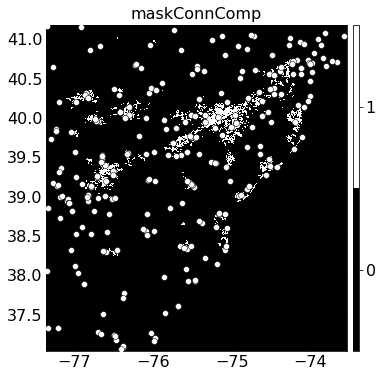

In [257]:
## check the masks
# cmd = f'{path_geom} waterMask --figsize 10 10 --noverbose'
# obj = view.main(cmd.split())

# cmd = f'{path_wd_mp / "maskTempCoh.h5"} --figsize 6 6 -c binary_r --noverbose'
# obj = view.main(cmd.split())

cmd = f'{path_wd_mp / "maskConnComp.h5"} --figsize 6 6 -c binary_r --noverbose --show-gps'
obj = view.main(cmd.split())

In [258]:
# optionally save a mask to kmz for plotting in google earth 
cmd  = f'save_kmz.py {path_wd_mp / "maskConnComp.h5"} -c binary_r -v 0 1 '
cmd += f'--cbar-loc "lower left" --cbar-bin-num 2 --cbar-label "MaskConnComp"'
print (cmd)
!{cmd}

save_kmz.py /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_106/FTML_ERA5_PM_MG_ex/maskConnComp.h5 -c binary_r -v 0 1 --cbar-loc "lower left" --cbar-bin-num 2 --cbar-label "MaskConnComp"
data   coverage in y/x: (0, 0, 4579, 4970)
subset coverage in y/x: (0, 0, 4579, 4970)
update LENGTH, WIDTH, Y/XMAX
update/add SUBSET_XMIN/YMIN/XMAX/YMAX: 0/0/4579/4970
update Y/X_FIRST
colormap: binary_r
plotting data ...
figure size : [12.0, 13.0]
no plot for reference point.
writing /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_106/FTML_ERA5_PM_MG_ex/maskConnComp.png with dpi=600
writing /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_106/FTML_ERA5_PM_MG_ex/maskConnComp_cbar.png
writing /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_106/FTML_ERA5_PM_MG_ex/maskConnComp.kml
remove /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_106/FTML_ERA5_PM_MG_ex/maskConnComp.kml
remove /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_106/FTML_ERA5

view.py /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex/avgSpatialCoh.h5 --figsize 6 6 -c binary_r --noverbose


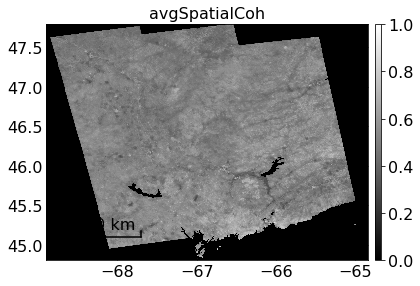

view.py /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex/temporalCoherence.h5 --figsize 6 6 -c binary_r --noverbose


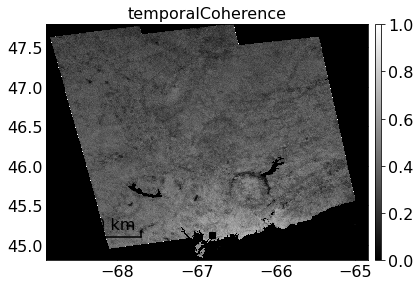

view.py /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex/velocity.h5 velocity --zm -u mm -v -5 5 --figsize 6 6 -c vik --noverbose


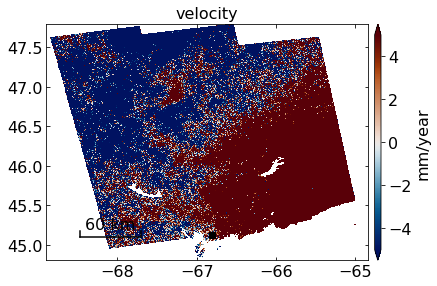

In [342]:
cmd = f'{path_wd_mp / "avgSpatialCoh.h5"} --figsize 6 6 -c binary_r --noverbose'
obj = view.main(cmd.split())

cmd = f'{path_wd_mp / "temporalCoherence.h5"} --figsize 6 6 -c binary_r --noverbose'
obj = view.main(cmd.split())

cmd = f'{path_wd_mp / "velocity.h5"} velocity --zm -u mm -v -5 5 --figsize 6 6 -c vik --noverbose'
obj = view.main(cmd.split())

generate_mask.py /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex/temporalCoherence.h5 -m 0.4 -o /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex/maskTempCoh.h5
input temporalCoherence file: /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex/temporalCoherence.h5
read /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex/temporalCoherence.h5
create initial mask with the same size as the input file and all = 1
all pixels with nan value = 0
exclude pixels with value < 0.4
delete exsited file: /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex/maskTempCoh.h5
create HDF5 file: /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex/maskTempCoh.h5 with w mode
create dataset /mask of bool       in size of (3577, 4878)         with compression=None
finished writing to /u/leffe-data2/buzzanga/data/VLM/Sentinel1/East

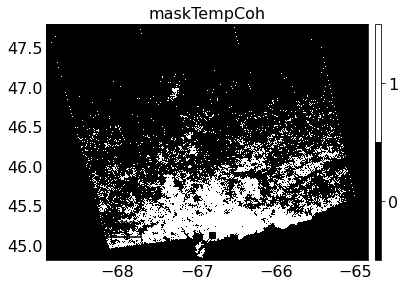

In [352]:
# remake a mask of TEMPORAL coherence
tthresh = 0.4
cmd = f'generate_mask.py {path_wd_mp / "temporalCoherence.h5"} -m {tthresh} -o {path_wd_mp / "maskTempCoh.h5"}'
print (cmd)
!{cmd}

cmd = f'{path_wd_mp / "maskTempCoh.h5"} --figsize 6 6 -c binary_r --noverbose'
obj = view.main(cmd.split())


generate_mask.py /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex/avgSpatialCoh.h5 -m 0.5 -o /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex/maskSpatialCoh.h5
input coherence file: /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex/avgSpatialCoh.h5
read /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex/avgSpatialCoh.h5
create initial mask with the same size as the input file and all = 1
all pixels with nan value = 0
exclude pixels with value < 0.5
delete exsited file: /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex/maskSpatialCoh.h5
create HDF5 file: /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex/maskSpatialCoh.h5 with w mode
create dataset /mask of bool       in size of (3577, 4878)         with compression=None
finished writing to /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track

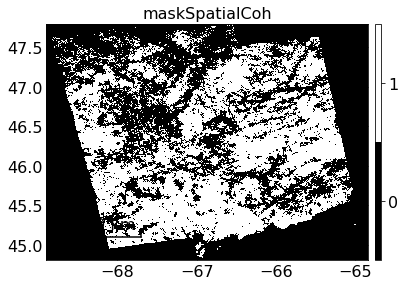

In [355]:
# make a mask of SPATIAL coherence and check how it aligns with number of inverted pixels
## already exists, but can update threshold
sthresh = 0.5
cmd = f'generate_mask.py {path_wd_mp / "avgSpatialCoh.h5"} -m {sthresh} -o {path_wd_mp / "maskSpatialCoh.h5"}'
print (cmd)
!{cmd}

cmd = f'{path_wd_mp / "maskSpatialCoh.h5"} --figsize 6 6 -c binary_r --noverbose'
obj = view.main(cmd.split())

view.py /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex/numInvIfgram.h5 --figsize 6 6 -c afmhot_r --noverbose


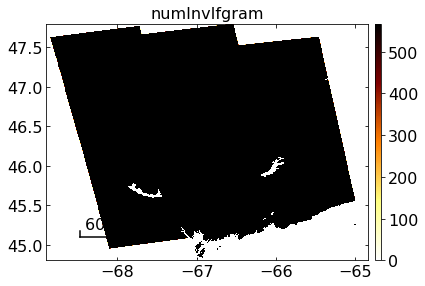

In [345]:
cmd = f'{path_wd_mp / "numInvIfgram.h5"} --figsize 6 6 -c afmhot_r --noverbose'
obj = view.main(cmd.split())

Using 3 masks
--------------------------------------------------
open  HDF5 file /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex/maskWaterTempCoh.h5 in a mode
writing dataset /waterMask                 block: [0, 3577, 0, 4878]
--------------------------------------------------
open  HDF5 file /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex/maskWaterTempCoh.h5 in a mode
writing dataset /mask                      block: [0, 3577, 0, 4878]
close HDF5 file /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex/maskWaterTempCoh.h5.
Wrote combined mask to: /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex/maskWaterTempCoh.h5
view.py /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex/maskWaterTempCoh.h5 --noverbose -c binary


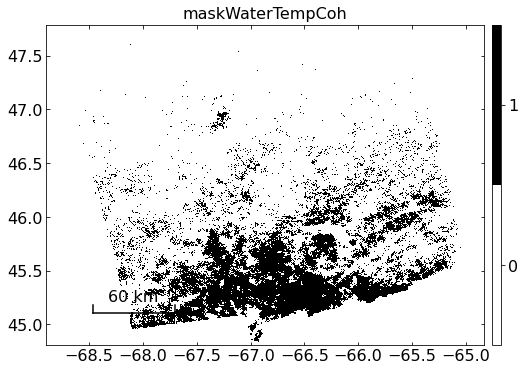

In [356]:
# always use water and temp coherence
use_masks = [path_wd_mp / 'maskTempCoh.h5', path_wd_mp / 'maskSpatialCoh.h5', path_wd_mp / 'waterMask.h5'] 
# use_masks = [path_wd_mp / 'maskSpatialCoh.h5', path_wd_mp / 'waterMask.h5'] 

# use_masks.append(Exp.path_mask_vel_geo) # velocity -5 5
# use_masks.append(Exp.path_mask_vsig_geo) # unc < 1.25                 
# use_masks.append(Exp.path_mask_velS_geo) # significant vel
# use_masks.append(Exp.path_mask_residue_geo) # ts residual
                 
path_mask = combine_masks(use_masks, apply_osm=False, show=True)

In [357]:
## plot timeseries image
cmd = f'{path_wd_mp / "timeseries.h5"} -m {path_mask} -u cm -v -5 5 --ram {max_mem} --save -c roma_r'
cmd = f'{cmd} --nodisplay --noverbose --nrows 5 --ncols 5'
view.main(cmd.split())
!mv {path_wd_mp / 'timeseries*.png'} {path_wd_mp / "pic"}

view.py /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex/timeseries.h5 -m /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex/maskWaterTempCoh.h5 -u cm -v -5 5 --ram 32 --save -c roma_r --nodisplay --noverbose --nrows 5 --ncols 5


<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

In [ ]:
## plot unwrapped and wrapped phase kept only
cmd = f'{path_wd_mp / "inputs" / "ifgramStack.h5"} unwrapPhase -m {path_mask} -v -25 25 --ram {max_mem} --save -c PRGn --show-kept --nrows 5 --cols 5'
cmd = f'{cmd} --nodisplay ' # --noverbose

print (f'view.py {cmd}')
view.main(cmd.split())

In [ ]:
cmd = f'{path_wd_mp / "inputs" / "ifgramStack.h5"} unwrapPhase -m {path_mask} --ram {max_mem} --wrap'
cmd = f'{cmd} --show-kept --wrap --nodisplay --save --nrows 5 --cols 5' # --noverbose
print (f'view.py {cmd}')
view.main(cmd.split())

In [358]:
# move the newly created files
for f in path_wd_mp.glob('*.png'):
    dst = path_wd_mp / 'pic' / f'{f.stem}_kept{f.suffix}'
    f.rename(dst)

## Write netcdfs, kmzs

In [364]:
# if the mask isnt written correctly, just keep running until it is...

cmds = [
        f'save_gdal.py {path_vlos} -d velocity -o {path_vlos.with_suffix(".nc")} --of netCDF',
        f'save_gdal.py {path_vlos} -d velocityStd -o {path_vlos.parent / "velocityStd.nc"} --of netCDF',
        f'save_gdal.py {path_mask} -o {path_mask.with_suffix(".nc")} --of netCDF',
        ]

# if 'Fast' in mp_exp:
#     cmds.append(f'save_gdal.py {Exp.path_vup_geo} -d residue -o {Exp.path_resid_nc} --of netCDF')

if path_vlos_pm.exists():
    cmds.append(f'save_gdal.py {path_vlos_pm} -d velocity -o {path_vlos_pm.with_suffix(".nc")} --of netCDF')

    
for cmd in cmds:
    print (cmd)
    !{cmd}

print ('\nWrote new netcdfs @', datetime.now())

save_gdal.py /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex/velocity.h5 -d velocity -o /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex/velocity.nc --of netCDF
read velocity from file: /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex/velocity.h5
/u/leffe-data2/buzzanga/Miniconda3/envs/ARIA/lib/python3.9/site-packages/mintpy/save_gdal.py:57: UserWarning: No EPSG or UTM_ZONE metadata found! Assume EPSG = 4326 (WGS84) and continue.
  warnings.warn(msg)
initiate GDAL driver: Network Common Data Format
create raster band:
  raster row / column number: 3577, 4878
  raster data type: 6 (float32)
set transform info: (-68.899139107, 0.000833333, 0, 47.787480885, 0, -0.000833333)
set projection as: EPSG 4326
write data to raster band
finished writing to /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex/velocity.nc
save_gdal.py /u/leffe-data2/buzzanga/data/VLM/Senti

In [365]:
## apply the mask to rate and std
mask  = xr.open_dataset(path_mask.with_suffix(".nc"))['Band1']
mask1 = mask.where(~np.isclose(mask, 0), np.nan)

rate = xr.load_dataset(path_vlos.with_suffix(".nc"))['Band1']
unc  = xr.load_dataset(path_vlos.parent / "velocityStd.nc")['Band1']

rate_m = rate * mask1
unc_m  = unc  * mask1

for i, nc in enumerate([rate_m, unc_m]):#, resid_m]):
    units    = 'm/y' if i < 2 else 'm'
    nc.attrs = {'units': units, 'region': dct_reg[track]}
    
try:
    os.remove(path_vlos.with_suffix(".nc"))
    os.remove(path_vlos.parent / "velocityStd.nc")
except:
    pass

# write the masked versions for plotting and transects
rate_m.to_netcdf(path_vlos.parent / "velocity_masked.nc")
unc_m.to_netcdf(path_vlos.parent / "velocityStd_masked.nc")

print ('Not using plate motion')
print (f'Wrote masked rates to {path_vlos.parent / "velocity_masked.nc"}, {datetime.now()}.')
# del mask, rate, unc, rate_m, unc_m

Not using plate motion
Wrote masked rates to /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex/velocity_masked.nc, 2023-09-29 13:32:17.470028.


In [366]:
cmd  = f'save_kmz.py {path_spacoh} coherence --zero-mask -c gray -v 0 1 '
cmd += f'--cbar-loc "lower left" --cbar-bin-num 10 --cbar-label "Average Spatial Coherence"'
# cmd = f'{cmd} --sub-lat 25.375 26.1875'
print (cmd)
!{cmd}


cmd = f'save_kmz.py {path_vlos}  velocity -m {path_mask1} -u cm -c coolwarm -v -10 10 '
cmd+= f'--cbar-loc "lower left" --cbar-bin-num 10 --cbar-label "Vertical Rate" -o {path_wd_mp / f"velocityA{track}"}'
# cmd = f'{cmd} --sub-lat 25.375 26.1875'
print (cmd)
# !{cmd}

save_kmz.py /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex/avgSpatialCoh.h5 coherence --zero-mask -c gray -v 0 1 --cbar-loc "lower left" --cbar-bin-num 10 --cbar-label "Average Spatial Coherence"
data   coverage in y/x: (0, 0, 4878, 3577)
subset coverage in y/x: (0, 0, 4878, 3577)
update LENGTH, WIDTH, Y/XMAX
update/add SUBSET_XMIN/YMIN/XMAX/YMAX: 0/0/4878/3577
update Y/X_FIRST
masking out pixels with zero value
Un-scalable display unit: cm
colormap: gray
plotting data ...
figure size : [16.4, 12.0]
no plot for reference point.
writing /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex/avgSpatialCoh.png with dpi=600
writing /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex/avgSpatialCoh_cbar.png
writing /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex/avgSpatialCoh.kml
remove /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex/

In [367]:
os.chdir(path_wd_mp)

path_mask1 = path_wmask # path_mask
# path_mask1 = path_wd_mp / 'waterMask.h5' #path_mask

dct_clims = {33: '-10 10'}

clims = dct_clims.get(track, '-10 10')

cmd  = f'save_kmz.py {path_vlos} velocity -m {path_mask1} -u mm -c vik -v {clims} '
cmd += f'--cbar-loc "lower left" --cbar-bin-num 10 --cbar-label "Vertical Rate"'
# cmd = f'{cmd} --sub-lat 25.375 26.1875'
print (cmd)
!{cmd}


cmd = f'save_kmz.py {path_vlos} velocityStd -m {path_mask1} -u mm -c afmhot_r -v 0 10 '
cmd+= f'--cbar-loc "lower left"  --cbar-bin-num 10 --cbar-label "Vertical Rate Uncertainty"'
# cmd = f'{cmd} --sub-lat 25.375 26.1875'
print (cmd)
!{cmd}

if path_vlos_pm.exists():
    cmd  = f'save_kmz.py {path_vlos_pm} velocity -m {path_mask1} -u mm -c vik -v {clims} '
    cmd += f'--cbar-loc "lower left" --cbar-bin-num 10 --cbar-label "Vertical Rate"'
    # cmd = f'{cmd} --sub-lat 25.375 26.1875'
    print (cmd)
    !{cmd}

save_kmz.py /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex/velocity.h5 velocity -m /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex/waterMask.h5 -u mm -c vik -v -10 10 --cbar-loc "lower left" --cbar-bin-num 10 --cbar-label "Vertical Rate"
data   coverage in y/x: (0, 0, 4878, 3577)
subset coverage in y/x: (0, 0, 4878, 3577)
update LENGTH, WIDTH, Y/XMAX
update/add SUBSET_XMIN/YMIN/XMAX/YMAX: 0/0/4878/3577
update Y/X_FIRST
update REF_Y/X
read mask from file: waterMask.h5
masking out pixels with zero value in file: /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex/waterMask.h5
colormap: vik
plotting data ...
figure size : [16.4, 12.0]
show reference point
writing /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex/velocity.png with dpi=600
writing /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_091/GEO2_ERA5_PM_MG_ex/velocity_cbar.png
writing /u/leffe

## Modify Network - WIP

- play with modify_network.py but then manually write into the exclude_network.txt and rerun smallbaselineApp.py
- careful with residualRMS as exclude_dates.txt can get updated by it unless you specify inf
- the coherenceSpatialAvg.txt only file gets written when modify_network coherence is on

In [50]:
## first just look at the ifgs in the raw stack
df_all = stack2df(Exp.path_ifgramStack, drop=False)[0]

print (df_all.head())
print ('Total ifgs:', df_all.shape)

        ref       sec      bperp       coh
0  20170217  20170313 -22.236898  0.926593
1  20170217  20170325 -45.368774  0.890108
2  20170217  20170406  71.971603  0.845201
3  20170217  20180119 -29.901390  0.853125
4  20170217  20180131 -93.611145  0.848119
Total ifgs: (566, 4)


In [51]:
df_used = stack2df(Exp.path_ifgramStack, drop=True)[0]
print (df_used)
print ('Total USED ifgs:', df_used.shape)

          ref       sec       bperp       coh
0    20170217  20170313  -22.236898  0.926593
1    20170313  20170325  -27.849474  0.924628
2    20170313  20170418  118.532814  0.886125
3    20170313  20180212  -27.473732  0.865364
4    20170406  20170418   32.705963  0.873401
..        ...       ...         ...       ...
159  20220227  20220404   54.934872  0.907788
160  20220311  20220404  -12.506633  0.923562
161  20220323  20220404  -79.489700  0.904778
162  20220404  20220428   25.449055  0.901775
163  20220404  20220510  -16.870518  0.894351

[164 rows x 4 columns]
Total USED ifgs: (164, 4)


#### Modify network 

- ONLY IF NOT USING CFG FILE

In [95]:
# remove random end dates 
end = '20210101'
for mint_dir in path_mps:
    path_stack = op.join(mint_dir, 'inputs', 'ifgramStack.h5')
    cmd = f'modify_network.py {path_stack} --end-date {end}'
#     !{cmd}

No lookup table info range/lat found in files.
open ifgramStack file: ifgramStack.h5
number of interferograms: 535
--------------------------------------------------
Drop ifgrams with date later than: 20210101 (3)
['20210606_20210618', '20210606_20210712', '20210712_20210805']
--------------------------------------------------
number of interferograms to remove: 3
number of interferograms to keep  : 532
number of acquisitions to remove: 4
['20210606', '20210618', '20210712', '20210805']
open file /u/leffe-data2/buzzanga/data/VLM/Sentinel1/HR_ARIA/MintPy_VAHP/inputs/ifgramStack.h5 with r+ mode
update HDF5 dataset "/dropIfgram".
update MODIFICATION_TIME in HDF5 dataset "/unwrapPhase"
update MODIFICATION_TIME in HDF5 dataset "/coherence"
update MODIFICATION_TIME in HDF5 dataset "/connectComponent"
touch coherenceSpatialAvg.txt
Done.
No lookup table info range/lat found in files.
open ifgramStack file: ifgramStack.h5
number of interferograms: 535
-------------------------------------------

In [26]:
# remove annual pairs and end
tbase = '100' # days
for mint_dir in path_mps:
    path_stack = op.join(mint_dir, 'inputs', 'ifgramStack.h5')
    cmd = f'modify_network.py {path_stack} --max-tbase {tbase} --end {end}'
    !{cmd}

No lookup table info range/lat found in files.
open ifgramStack file: ifgramStack.h5
number of interferograms: 535
--------------------------------------------------
Drop ifgrams with temporal baseline > 100.0 days: (183)
['20150310_20150825', '20150310_20160409', '20150310_20160702', '20150310_20161006', '20150310_20161018', '20150310_20161030', '20150310_20161111', '20150310_20161123', '20150310_20161205', '20150310_20161217', '20150310_20161229', '20150310_20170110', '20150310_20170122', '20150310_20170203', '20150310_20170215', '20150310_20170227', '20150310_20170311', '20150310_20170323', '20150310_20170404', '20150825_20160409', '20150825_20160702', '20150825_20161006', '20150825_20161018', '20150825_20161030', '20150825_20161111', '20150825_20161123', '20150825_20161205', '20150825_20161217', '20150825_20161229', '20150825_20170110', '20150825_20170122', '20150825_20170203', '20150825_20170215', '20150825_20170227', '20150825_20170311', '20150825_20170323', '20150825_20170404', 

update MODIFICATION_TIME in HDF5 dataset "/coherence"
update MODIFICATION_TIME in HDF5 dataset "/connectComponent"
touch coherenceSpatialAvg.txt
Done.


#### Check Network

In [ ]:
# doesnt look like its getting the updated network - probably because I just use in velocity

In [231]:
# check the conversion
print (f'{ref_sta}:')
check_network.main(Exp.path_ifgramStack)
print ('')

# make the network plot
# cmd = f'plot_network.py {Exp.path_ifgramStack} -d tbase --save --nodisplay'
cmd = f'plot_network.py {Exp.path_ifgramStack} -d tbase --save --nodisplay --show-kept'

!{cmd}

# add dfs to list to optionally compare later
df = stack2df(Exp.path_ifgramStack)[0]
df.attrs['sta'] = ref_sta
dfs.append(df)

VAHP:
number of acquisitions  : 161
number of interferograms: 776
number of lines   : 571
number of columns : 874
Reference date : 20150310
-------------------------------------------------------------------------------
***GOOD: The network is fully connected.
-------------------------------------------------------------------------------

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
Traceback (most recent call last):
  File "/u/leffe-data2/buzzanga/Software_InSAR/MintPy_git/mintpy/plot_network.py", line 14, in <module>
    from mintpy.objects import ifgramStack
  File "/u/leffe-data2/buzzanga/Software_InSAR/MintPy_git/mintpy/__init__.py", line 2, in <module>
    from mintpy.version import (
  File "/u/leffe-data2/buzzanga/Software_InSAR/MintPy_git/mintpy/version.py", line 71, in <module>
    version, version_date = get_version_info()
  File "/u/leffe-data2/buzzanga/Software_InSAR/MintPy_git/mintpy/version.py", line

NameError: name 'sta' is not defined

In [23]:
from wand.image import Image as WImage
WImage(filename=op.join(path_mps[0], 'network.pdf'), resolution=100) # bigger

BlobError: unable to open image '/u/leffe-data2/buzzanga/data/VLM/Sentinel1/NYC_ARIA/MintPy_NYBP/network.pdf': No such file or directory @ error/blob.c/OpenBlob/3527

In [443]:
# check the ifgs if you want
# coherence doesnt match the .txt as that uses the regional masks
print (dfs[0].head())
# dfs[1].head(10)

        ref       sec      bperp       coh
0  20150320  20161203  27.013529  0.460727
1  20160419  20160712  24.184834  0.475675
2  20160712  20160805  15.998617  0.670445
3  20160805  20160928 -57.469234  0.487442
4  20160928  20161004  18.303087  0.670397


In [444]:
# check the RMS noise of aquisitions (Zhang 2019; 4.9)
from wand.image import Image as WImage
if Exp.reg == 'HR':
    WImage(filename=op.join(Exp.path_mp_VAHP, 'rms_timeseriesResidual_ramp.pdf'), resolution=100) 
    WImage(filename=op.join(Exp.path_mp_LOY2, 'rms_timeseriesResidual_ramp.pdf'), resolution=100) 
elif Exp.reg == 'Charleston':
    WImage(filename=op.join(Exp.path_mp_SCHA, 'rms_timeseriesResidual_ramp.pdf'), resolution=100) 

Number of ifgs with coh less than 0.525: 38
Number of ifgs with coh greater than 0.525: 227


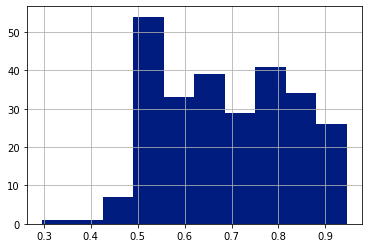

In [445]:
coh_thr = 0.525

for df in dfs:
    coh     = df.coh
    coh.hist()

    print (f'Number of ifgs with coh less than {coh_thr}:', (df.coh<coh_thr).sum())
    print (f'Number of ifgs with coh greater than {coh_thr}:', (df.coh>=coh_thr).sum())

# note that there will be some included that violate the threshold to keep the MST
# note that if you alter the excluded ifgs, the MST will then fill in with the highest coherence it can

#### Make uniform aqusition list

May have different networks for N/S. 
Need to make uniform shapes to combine.
Could either specify dates to exclude in both or do a set difference on dates (these are the same).

In [ ]:
from VLM import bbMP
ts      = 'demErr'
lst_slc = []
for mint_dir in [Exp.path_mp_VAHP, Exp.path_mp_LOY2]:
    dates = bbMP.get_aquisitions(mint_dir, path_ts=op.join(mint_dir, f'timeseries_{ts}'), use_all=False)
    lst_slc.append(dates)

In [ ]:
print (len(lst_slc[0]))
print (len(lst_slc[1]))

result =  all(elem in lst_slc[1] for elem in lst_slc[0])
print ('All items in shorter list are in longer, as expected?:', result)

_ = [print ('Missing aquisition:', i) for i in lst_slc[1] if not i in lst_slc[0]]

- See bottom for unwrapped, ts

#### Check HR Residual

view.py /u/leffe-data2/buzzanga/data/VLM/Sentinel1/HR_ARIA/LOY2_Base/velocity.h5 velocity -u mm -c roma --noverbose -v -5 5 --figsize 10 10 --zm


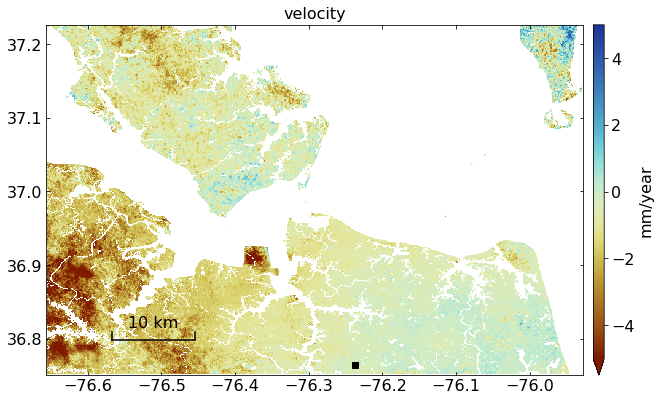

In [244]:
cmd = f'view.py {Exp.path_vel.replace("VAHP", "LOY2")} velocity -u mm -c roma --noverbose -v -5 5 --figsize {fs[0]} {fs[1]}'
cmd = f'{cmd} --zm '#'--mask {Exp.path_mask_tc}'

obj = viewer(cmd)
obj.configure(); obj.plot()

447516.0


499054

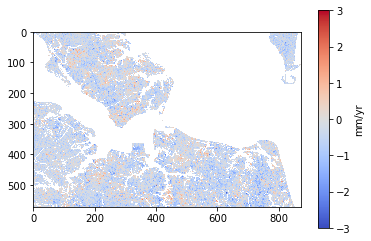

In [254]:
with h5py.File(Exp.path_vel, 'r') as h5:
    arr_vahp = h5['velocity'][:]
    
with h5py.File(Exp.path_vel.replace("VAHP", "LOY2"), 'r') as h5:   
    arr_loy2 = h5['velocity'][:]

resid = (arr_loy2-arr_vahp)*1000
resid = np.where(np.isclose(resid, 0), np.nan, resid)

plt.imshow(resid, origin='upper', cmap='coolwarm', vmin=-3, vmax=3, interpolation='nearest')
plt.colorbar(label='mm/yr')

print (np.nansum(np.where(resid>0, np.nan, 1)))
resid.size

tsview.py /u/leffe-data2/buzzanga/data/VLM/Sentinel1/HR_ARIA/LOYZ_TEST/timeseries.h5 --ms 4 -u mm -v -20 20 --ylim -20 20 -c roma --no-multilook --lalo 36.764016798 -76.237800713 --no-show-img -m no --noverbose
No lookup table info range/lat found in files.


/u/leffe-data2/buzzanga/Software_InSAR/MintPy_git/mintpy/tsview.py:936: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  self.fig_img.canvas.set_window_title(self.figname_img)


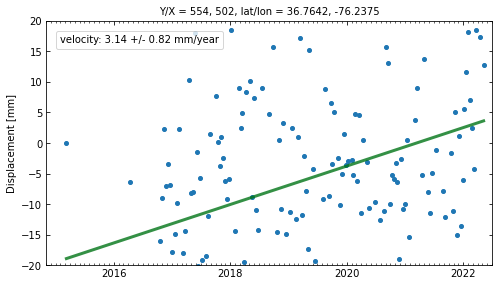

tsview.py /u/leffe-data2/buzzanga/data/VLM/Sentinel1/HR_ARIA/LOYZ_TEST/timeseries.h5 --ms 4 -u mm -v -20 20 --ylim -20 20 -c roma --no-multilook --lalo 37.062178 -76.403436 --no-show-img -m no --noverbose
No lookup table info range/lat found in files.


/u/leffe-data2/buzzanga/Software_InSAR/MintPy_git/mintpy/tsview.py:936: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  self.fig_img.canvas.set_window_title(self.figname_img)


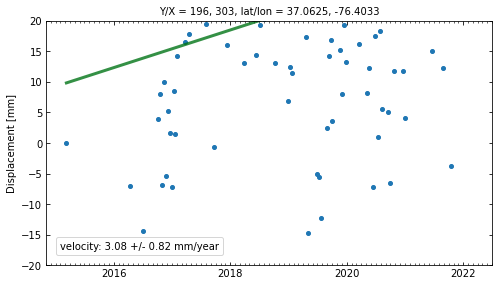

In [34]:
# compare timeseries at ref point; velocity at LOY2/VAHP are 3.14/3.08 mm/yr; i.e., very close.
# only works if they are referenced to a diff point

for sta in 'LOY2 VAHP'.split():
    cmd  = f'tsview.py {Exp.path_ts} --ms 4 -u mm -v -20 20 --ylim -20 20 -c roma --no-multilook '
    cmd += f'--lalo {DCT_GPS[sta]} --no-show-img -m no --noverbose'

    obj = timeseriesViewer(cmd)
    obj.configure(); obj.plot()


## Postprocess - WIP

### Setup

In [91]:
## Create a single water-only mask for MintPy
os.makedirs(Exp.path_mp_vup, exist_ok=True)
if Exp.reg == 'HR':
    
    from bzFRI.masking import make_waterMask
    assert 'LOY2' in op.basename(Exp.path_mp_exp), 'Use LOY2 for post-processing.'
    # aria mask will have to be same size as MintPY
    path_mask_crop = op.join(Exp.path_masks, 'OSM_wmask.msk')
    make_waterMask.main(path_mask_crop, Exp.path_mp_exp, Exp.path_mp_vup)
    path_mask_tc  = op.join(Exp.path_wd, f'maskTempCoh_{mp_exp}.h5')
    combine_masks(path_mask_tc, [Exp.path_mask_tc, Exp.path_mask_tc.replace('LOY2', 'VAHP')], False, True)
    
    
elif Exp.reg in 'Charleston NYC'.split():
    os.unlink(Exp.path_mask_vup) if op.islink(Exp.path_mask_vup) else ''
    os.symlink(Exp.path_mask_mp_geo, Exp.path_mask_vup)
    path_mask_tc = Exp.path_mask_tc

In [92]:
## save geocoded watermask mask to gdal for cropping N/S
cmd = f'save_gdal.py {Exp.path_mask_vup} -o {Exp.path_mask_vup_nc} --of netCDF'

print (cmd)
!{cmd}

save_gdal.py /u/leffe-data2/buzzanga/data/VLM/Sentinel1/HR_ARIA/LOY2_SET/Vup/waterMask.h5 -o /u/leffe-data2/buzzanga/data/VLM/Sentinel1/HR_ARIA/LOY2_SET/Vup/geo_waterMask.nc --of netCDF
read data from file: /u/leffe-data2/buzzanga/data/VLM/Sentinel1/HR_ARIA/LOY2_SET/Vup/waterMask.h5
/u/leffe-data2/buzzanga/Miniconda3/envs/FRInGE/lib/python3.10/site-packages/mintpy/save_gdal.py:57: UserWarning: No EPSG or UTM_ZONE metadata found! Assume EPSG = 4326 (WGS84) and continue.
  warnings.warn(msg)
convert data from boolean to uint8, as GDAL does not support boolean
initiate GDAL driver: Network Common Data Format
create raster band:
  raster row / column number: 571, 874
  raster data type: 1 (uint8)
set transform info: (-76.65625, 0.000833333, 0, 37.22625, 0, -0.000833333)
set projection as: EPSG 4326
write data to raster band
finished writing to /u/leffe-data2/buzzanga/data/VLM/Sentinel1/HR_ARIA/LOY2_SET/Vup/geo_waterMask.nc


In [93]:
dst_inps = op.join(Exp.path_mp_vup, 'inputs')
os.unlink(dst_inps) if op.islink(dst_inps) else ''

src_inps = op.join(Exp.path_mp_exp, 'inputs')
os.symlink(src_inps, dst_inps)

print (f'Linked:\n\t{src_inps} ->\n\t{dst_inps}\n')
print (datetime.now())

Linked:
	/u/leffe-data2/buzzanga/data/VLM/Sentinel1/HR_ARIA/LOY2_SET/inputs ->
	/u/leffe-data2/buzzanga/data/VLM/Sentinel1/HR_ARIA/LOY2_SET/Vup/inputs

2023-08-23 16:37:27.916764


### Subtract off the GPS EW projected to LOS [optional]

In [25]:
from VLM.bzFRInGE.contrib.plotting.plotLOS import proj_gps_en
from mintpy.utils import readfile, writefile

In [29]:
ds_gps_LOS = proj_gps_en(Exp)
gps_vel0   = np.flipud(ds_gps_LOS.data) # flip it to match the order of the data in the h5 and associated refs

# backup original LOS velocity
path_orig = f'{op.splitext(Exp.path_vel)[0]}_orig.h5'
!cp {Exp.path_vel} {path_orig}

In [30]:
## get the reference point for shifting the midas (verified using df_gps_LOS.sel and the REF_LAT)
insar_vel0, meta = readfile.read(path_orig)
ref_y, ref_x    = int(meta['REF_Y']), int(meta['REF_X'])
gps_ref         = gps_vel0[ref_y, ref_x]

gps_vel   = gps_vel0 - gps_ref
insar_vel = insar_vel0 - gps_vel
insar_vel = np.where(np.isnan(insar_vel), 0, insar_vel)

In [31]:
writefile.write_hdf5_block(Exp.path_vel, insar_vel, 'velocity')

--------------------------------------------------
open  HDF5 file /u/leffe-data2/buzzanga/data/VLM/Sentinel1/NYC_ARIA/NJHT_EW_Fast/velocity.h5 in a mode
writing dataset /velocity                  block: [0, 352, 0, 498]
close HDF5 file /u/leffe-data2/buzzanga/data/VLM/Sentinel1/NYC_ARIA/NJHT_EW_Fast/velocity.h5.


'/u/leffe-data2/buzzanga/data/VLM/Sentinel1/NYC_ARIA/NJHT_EW_Fast/velocity.h5'

### Reference and Save

In [95]:
# the southern portion to LOY2 and the upper to VAHP
from VLM.bzFRInGE.ref_proj import RefProj

# Obj = RefProj(Exp.path_mp_exp, Exp.reg, Exp.path_mask_vup_nc, corr='ARIA')
Obj = RefProj(Exp.path_mp_exp, Exp.reg, Exp.path_mask_vup_nc, path_mask_tc, corr='ARIA')

# if Exp.reg == 'HR':
#     Obj.proj_two()    

# else:

Obj.proj_one(Exp.ref_sta) # velocity.h5


Using: /u/leffe-data2/buzzanga/data/VLM/Sentinel1/HR_ARIA/LOY2_SET/velocity.h5


ValueError: operands could not be broadcast together with shapes (571,874) (353,534) 

In [67]:
cmd = f'save_gdal.py {Exp.path_vup_geo} -d velocity -o {Exp.path_rate_nc} --of netCDF'
!{cmd}

cmd = f'save_gdal.py {Exp.path_vup_geo} -d velocityStd -o {Exp.path_std_nc} --of netCDF'
!{cmd}

print ('Finished @:', datetime.now())

read velocity from file: /u/leffe-data2/buzzanga/data/VLM/Sentinel1/NYC_ARIA/NYBK_ERA5_SET_PM_ex_Fast/Vup/Vup_ERA5_SET_PM_ex_Fast_ARIA.h5
/u/leffe-data2/buzzanga/Miniconda3/envs/FRInGE/lib/python3.10/site-packages/mintpy/save_gdal.py:57: UserWarning: No EPSG or UTM_ZONE metadata found! Assume EPSG = 4326 (WGS84) and continue.
  warnings.warn(msg)
initiate GDAL driver: Network Common Data Format
create raster band:
  raster row / column number: 353, 534
  raster data type: 6 (float32)
set transform info: (-74.200803653, 0.000833333, 0, 40.824150337, 0, -0.000833333)
set projection as: EPSG 4326
write data to raster band
finished writing to /u/leffe-data2/buzzanga/data/VLM/Sentinel1/NYC_ARIA/NYBK_ERA5_SET_PM_ex_Fast/Vup/geo_rate_ARIA.nc
read velocityStd from file: /u/leffe-data2/buzzanga/data/VLM/Sentinel1/NYC_ARIA/NYBK_ERA5_SET_PM_ex_Fast/Vup/Vup_ERA5_SET_PM_ex_Fast_ARIA.h5
/u/leffe-data2/buzzanga/Miniconda3/envs/FRInGE/lib/python3.10/site-packages/mintpy/save_gdal.py:57: UserWarning: N

In [71]:
v_clims = '-5 5' if Exp.reg in 'HR '.split() else '-5 5'

cmd = f'save_kmz.py {Exp.path_vup_geo} velocity -m {Exp.path_mask_vup} -u mm -c vik -v {v_clims} '
cmd += f'-o {Exp.path_vel_kmz} --cbar-loc "lower left" --cbar-bin-num 10 --cbar-label "Vertical Rate"'
print (cmd)
!{cmd}

cmd = f'save_kmz.py {Exp.path_vup_geo} velocityStd -m {Exp.path_mask_vup} -u mm -c afmhot_r -v 0 3 '
cmd+= f'-o {Exp.path_std_kmz} --cbar-loc "lower left"  --cbar-bin-num 5 --cbar-label "Vertical Rate Uncertainty"'
print (cmd)
!{cmd}

# cmd = f'save_kmz.py {Exp.path_vup_geo} residue -m {Exp.path_mask_vup} -u mm -c BrBG -v 0 250 '
# cmd+= f'-o {Exp.path_resid_kmz} --cbar-loc "lower left"  --cbar-bin-num 10 --cbar-label "Vertical Rate Residue"'
# print (cmd)
# !{cmd}

save_kmz.py /u/leffe-data2/buzzanga/data/VLM/Sentinel1/NYC_ARIA/NYBK_ERA5_SET_PM_ex_Fast/Vup/Vup_ERA5_SET_PM_ex_Fast_ARIA.h5 velocity -m /u/leffe-data2/buzzanga/data/VLM/Sentinel1/NYC_ARIA/NYBK_ERA5_SET_PM_ex_Fast/Vup/waterMask.h5 -u mm -c vik -v -5 5 -o /u/leffe-data2/buzzanga/data/VLM/Sentinel1/NYC_ARIA/NYBK_ERA5_SET_PM_ex_Fast/Vup/geo_rate_ARIA --cbar-loc "lower left" --cbar-bin-num 10 --cbar-label "Vertical Rate"
data   coverage in y/x: (0, 0, 534, 353)
subset coverage in y/x: (0, 0, 534, 353)
update LENGTH, WIDTH, Y/XMAX
update/add SUBSET_XMIN/YMIN/XMAX/YMAX: 0/0/534/353
update Y/X_FIRST
update REF_Y/X
read mask from file: waterMask.h5
masking out pixels with zero value in file: /u/leffe-data2/buzzanga/data/VLM/Sentinel1/NYC_ARIA/NYBK_ERA5_SET_PM_ex_Fast/Vup/waterMask.h5
colormap: vik
plotting data ...
figure size : [18.2, 12.0]
show reference point
writing /u/leffe-data2/buzzanga/data/VLM/Sentinel1/NYC_ARIA/NYBK_ERA5_SET_PM_ex_Fast/Vup/geo_rate_ARIA.png with dpi=600
writing /u/le

## Plot Velocity

In [246]:
%matplotlib inline
# path  = f'{Exp.path_mp_exp}/velocity.h5'

path_vel  = path_vlos_pm # vel
path_velS = path_vlos # velStd
mask      = path_mask # combined mask
dct_vel_clims = {164: '-10 10'}
vel_clims     = dct_vel_clims.get(track, '-10 10')

parms = f'-u mm --figsize 10 10 -m {mask} -d {path_geom} --noverbose' #--show-gps

cmd = f'{path_vel} velocity -c roma_r -v {vel_clims} {parms}'
view.main(cmd.split())

cmd = f'{path_velS} velocityStd  -c afmhot_r -v 0 1.5 {parms}'
view.main(cmd.split())

FileNotFoundError: input file file /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/track_062/MAMI_ERA5_PM_ex/velocity_ITRF14.h5 NOT exist!

In [ ]:
## Comparisons minus ramp

## LOS
path_orig = f'{op.splitext(Exp.path_vel)[0]}_orig.h5'
cmd = f'{path_orig} velocity -u mm -c roma_r --noverbose --figsize {fs[0]} {fs[1]} -v -5 5'
cmd = f'{cmd} --title  LOS_Velocity'
view.main(cmd.split())

## LOS - GPS Ramp
cmd = f'{Exp.path_vel} velocity -u mm -c roma_r --noverbose --figsize {fs[0]} {fs[1]} -v -5 5'
cmd = f'{cmd} --title  LOS_Velocity-EW'
view.main(cmd.split())

!diff.py {path_orig} {Exp.path_vel} -o {Exp.path_cmp}/en_diff.h5
cmd = f'{Exp.path_cmp}/en_diff.h5 velocity -u mm -c cmc.bam --noverbose --figsize {fs[0]} {fs[1]} -v -1 1'
cmd = f'{cmd} --title  Residual_Orig-Corrected'
view.main(cmd.split())

## Plot Ifgs / TS

### Line of Sight

In [82]:
%matplotlib notebook

Couldn't get wrapPhase in /u/leffe-data2/buzzanga/data/VLM/Sentinel1/NYC_ARIA_SRTM/NYBP_Base/inputs/ifgramStack.h5


<IPython.core.display.Javascript object>


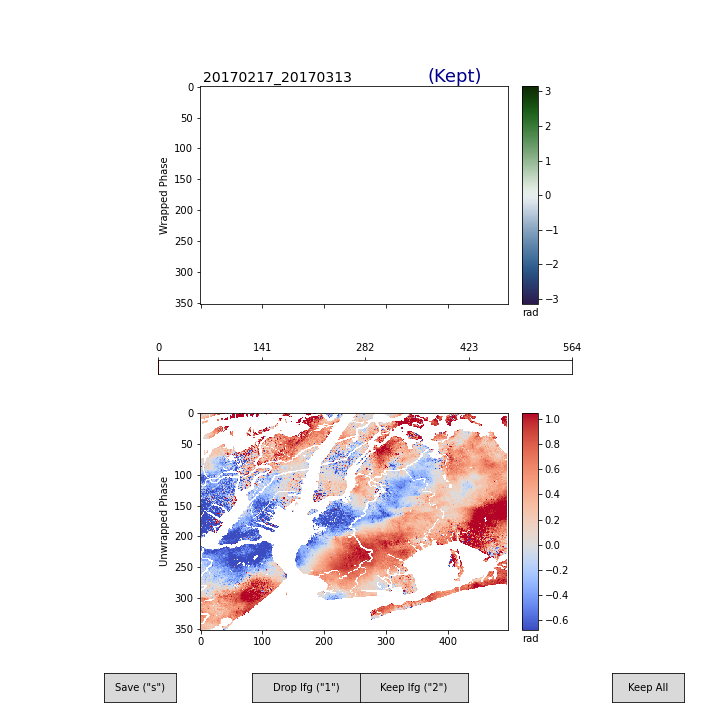

In [83]:
## plot the wrapped vs unwrapped
stack   = op.join(Exp.path_mp_exp, 'inputs', 'ifgramStack.h5')
mask    = op.join(Exp.path_mp_exp, 'waterMask.h5')
Plotter = plotStack.PlotWrapUnwrap(stack, mask, figsize=(10, 10))
Plotter.main()

In [87]:
path_dem = op.join(Exp.path_wd, 'DEM', 'SRTM_3arcsec.dem')

tsview.py /u/leffe-data2/buzzanga/data/VLM/Sentinel1/NYC_ARIA_SRTM/NYBP_Base/timeseries_demErr.h5 -d /u/leffe-data2/buzzanga/data/VLM/Sentinel1/NYC_ARIA_SRTM/DEM/SRTM_3arcsec.dem --ms 4 -u mm -v -20 20 --ylim -20 20 -c roma --mask /u/leffe-data2/buzzanga/data/VLM/Sentinel1/NYC_ARIA_SRTM/NYBP_Base/waterMask.h5
open timeseries file: timeseries_demErr.h5
No lookup table info range/lat found in files.
data   coverage in y/x: (0, 0, 498, 352)
subset coverage in y/x: (0, 0, 498, 352)
data   coverage in lat/lon: (-74.171220331, 40.823733671, -73.756220497, 40.530400455)
subset coverage in lat/lon: (-74.171220331, 40.823733671, -73.756220497, 40.530400455)
------------------------------------------------------------------------
estimate deformation model with the following assumed time functions:
    polynomial : 1
    periodic   : []
    stepDate   : []
    exp        : {}
    log        : {}
reading timeseries from file /u/leffe-data2/buzzanga/data/VLM/Sentinel1/NYC_ARIA_SRTM/NYBP_Base/times

<IPython.core.display.Javascript object>


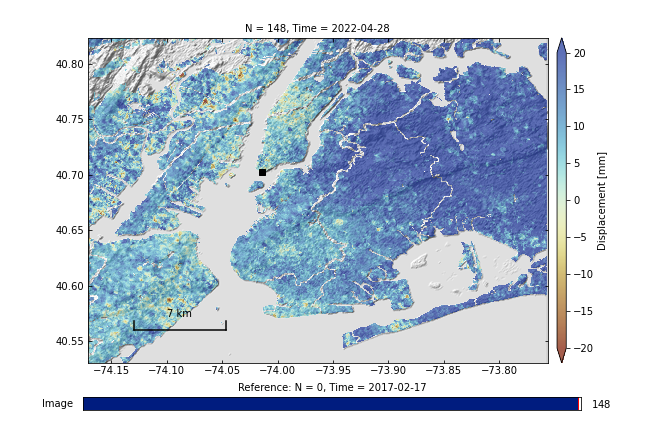

reading DEM: SRTM_3arcsec.dem ...
display data in transparency: 0.7
plot in geo-coordinate
plotting DEM background ...
show shaded relief DEM (min/max=-4000/2150 m; exag=0.5; az/alt=315.0/45.0 deg)
plotting image ...
plot scale bar: [0.2, 0.2, 0.1]
plot reference point
create figure for point in size of [8.0, 4.5]


<IPython.core.display.Javascript object>


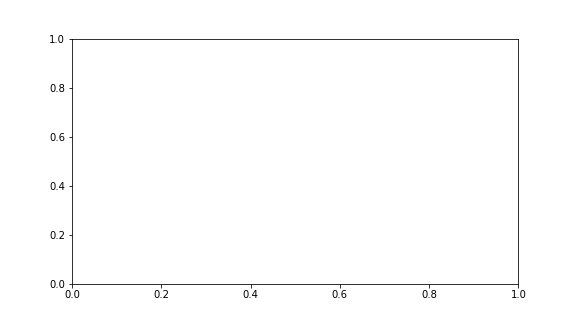

showing ...

------------------------------------------------------------------------
To scroll through the image sequence:
1) Move the slider, OR
2) Press left or right arrow key (if not responding, click the image and try again).
------------------------------------------------------------------------


In [85]:
# note that the GPS value is not subtracted
## view the raw | -dem | -dem, geo | whatever corrections i have in experiment
path_ts = op.join(Exp.path_mp_exp, 'timeseries_demErr.h5')
cmd  = f'{path_ts} -d {path_dem} --ms 4 -u mm -v -20 20 --ylim -20 20 -c roma '# --no-multilook '
cmd += f'--mask {mask} '
# cmd += '--yx 1376 986'
# cmd += f'--ref-lalo {Exp.dct_gps["LOY2"]} '

obj = tsview.main(cmd.split())
# obj.figsize_img = [10, 8]
# obj.figsize_pts = [10, 4]

In [86]:
path_atm = op.join(Exp.path_mp_exp.replace('Base', 'ERA5'), 'inputs', 'ERA5.h5')

tsview.py /u/leffe-data2/buzzanga/data/VLM/Sentinel1/NYC_ARIA_SRTM/NYBP_ERA5/inputs/ERA5.h5 --ms 4 -u mm --mask /u/leffe-data2/buzzanga/data/VLM/Sentinel1/NYC_ARIA_SRTM/NYBP_Base/waterMask.h5
open timeseries file: ERA5.h5
No lookup table info range/lat found in files.
data   coverage in y/x: (0, 0, 498, 352)
subset coverage in y/x: (0, 0, 498, 352)
data   coverage in lat/lon: (-74.171220331, 40.823733671, -73.756220497, 40.530400455)
subset coverage in lat/lon: (-74.171220331, 40.823733671, -73.756220497, 40.530400455)
------------------------------------------------------------------------
estimate deformation model with the following assumed time functions:
    polynomial : 1
    periodic   : []
    stepDate   : []
    exp        : {}
    log        : {}
reading timeseries from file /u/leffe-data2/buzzanga/data/VLM/Sentinel1/NYC_ARIA_SRTM/NYBP_ERA5/inputs/ERA5.h5
read mask from file: waterMask.h5
data    range: [-3382.9888, -2861.358] mm
display range: [-3366.2358, -2868.7373] mm
cre

<IPython.core.display.Javascript object>


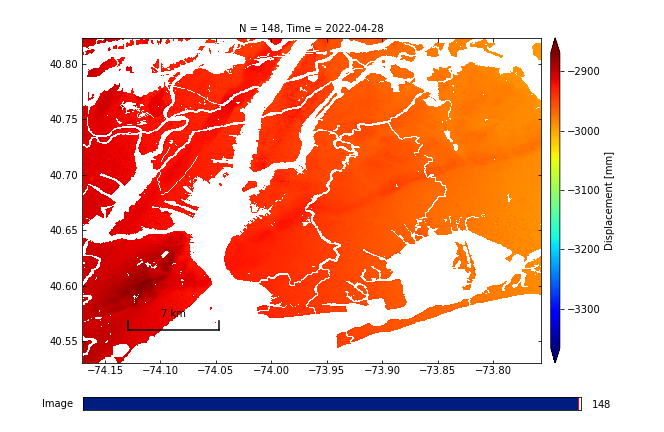

display data in transparency: 1.0
plot in geo-coordinate
plotting image ...
plot scale bar: [0.2, 0.2, 0.1]
create figure for point in size of [8.0, 4.5]


<IPython.core.display.Javascript object>


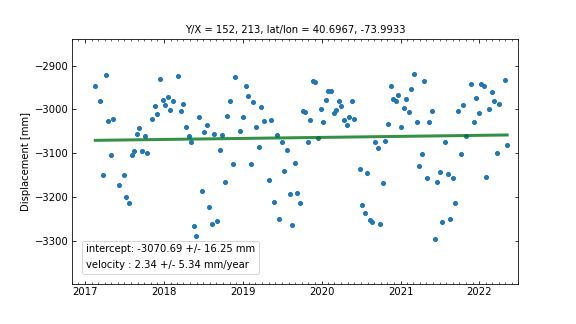

showing ...

------------------------------------------------------------------------
To scroll through the image sequence:
1) Move the slider, OR
2) Press left or right arrow key (if not responding, click the image and try again).
------------------------------------------------------------------------


In [81]:
%matplotlib notebook
# note that the GPS value is not subtracted
## view the raw | -dem | -dem, geo | whatever corrections i have in experiment
cmd  = f'{path_atm}  --ms 4 -u mm '#'-d {path_dem}'# --no-multilook '
cmd += f'--mask {mask} '
# cmd += f'--lalo 36.9732000 -76.4171000'

# cmd += '--yx 1376 986'
# cmd += f'--ref-lalo {Exp.dct_gps["LOY2"]} '

obj = tsview.main(cmd.split())
# obj.configure()
# obj.figsize_img = [10, 8]
# obj.figsize_pts = [10, 4]
# obj.plot()

### Plot Postage 

In [ ]:
%matplotlib inline
cmd = f'{Exp.path_ts_geo} -u cm -c roma_r --noverbose -v -5 5'#'--yx 40 40  --ylim -100 100 --vlim -100 100'
# tsview.main(cmd.split())

view.main(cmd.split())

### Vertical

view.py /u/leffe-data2/buzzanga/data/VLM/Sentinel1/NYC_ARIA/NJHT_Base_Fast/Vup/Vup_Base_Fast_ARIA.h5 velocity -u mm -c roma_r --noverbose -v -3 3 --figsize 10 10


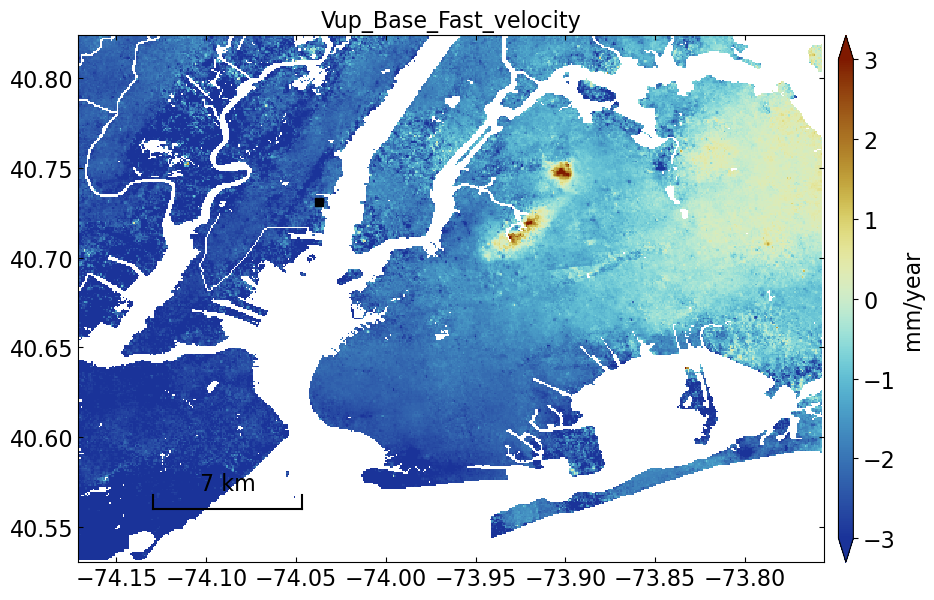

In [71]:
%matplotlib inline
Exp       = ARIABase(exp, 'Base_Fast', ref_sta) # to store in riht path

cmd = f'{Exp.path_vup_geo} velocity -u mm -c roma_r --noverbose -v -3 3 --figsize {fs[0]} {fs[1]}'
# cmd = f'{cmd} -m {path_mask_vup}' #path_v_mask_geo (<- significance), path_mask_ccgeo (<- connComp), path_mask_vup (<combined)

# cmd = f'{cmd} -m {Exp.path_mask_mp_geo}'

obj = view.main(cmd.split())

view.py /u/leffe-data2/buzzanga/data/VLM/Sentinel1/NYC_ARIA/NJHT_HRRR_Bridging_Fast/Vup/Vup_HRRR_Bridging_Fast_ARIA.h5 velocity -u mm -c roma_r --noverbose -v -3 3 --figsize 10 10


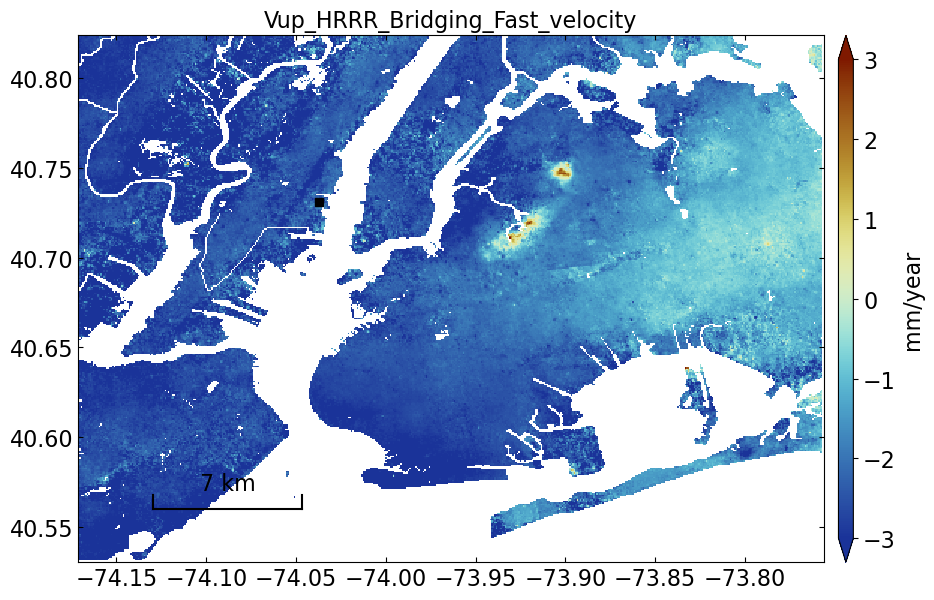

In [110]:
%matplotlib inline
cmd = f'{Exp.path_vup_geo} velocity -u mm -c roma_r --noverbose -v -3 3 --figsize {fs[0]} {fs[1]}'
# cmd = f'{cmd} -m {path_mask_vup}' #path_v_mask_geo (<- significance), path_mask_ccgeo (<- connComp), path_mask_vup (<combined)

# cmd = f'{cmd} -m {Exp.path_mask_mp_geo}'

obj = view.main(cmd.split())

In [92]:
rate = xr.open_dataset(Exp.path_rate_nc)['Band1']*1000
unc  = xr.open_dataset(Exp.path_std_nc)['Band1']*1000

## custom mask
rate = rate.where(rate>-7, np.nan)
rate = rate.where(rate<7, np.nan)
# rate = rate.where(unc<4, np.nan)

unc = unc.where(rate>-7, np.nan)
unc = unc.where (rate<7, np.nan)
# unc = unc.where(unc<4, np.nan)

# rate = rate.where(np.abs(rate)>0.5*unc, np.nan)
# unc  = unc.where(np.abs(rate)>0.5*unc, np.nan)

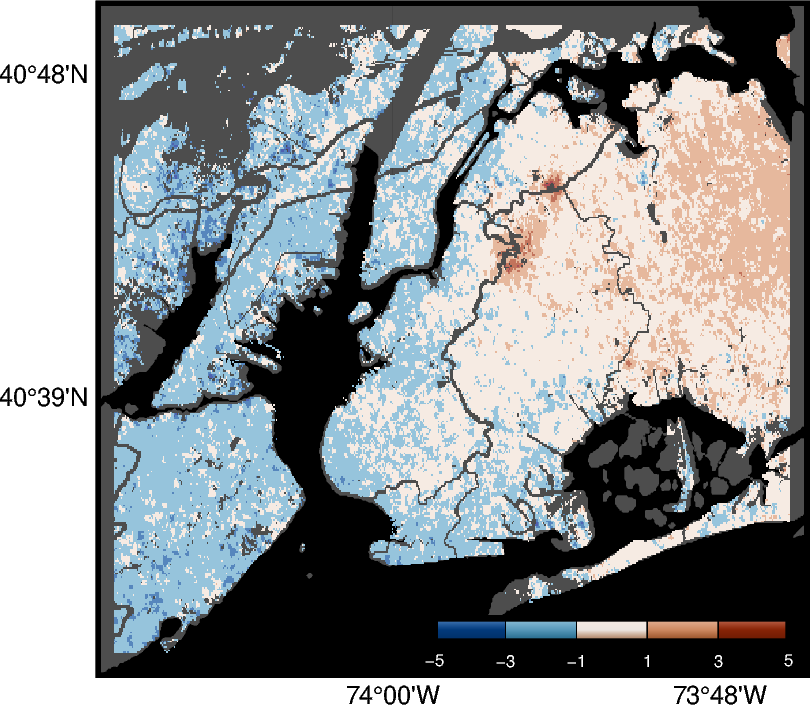

In [98]:
PlotObj = plotGMT.PlotVLM(Exp.reg, Exp.path_mp_vup)

fig = PlotObj.plot_basic(rate, 'rate')
fig.show(dpi=600, width=800)

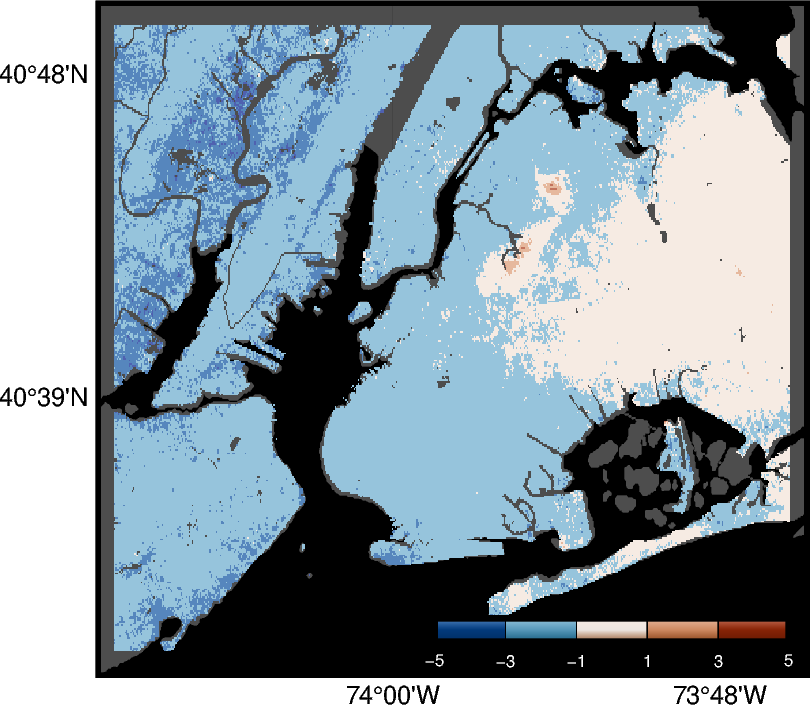

In [93]:
PlotObj = plotGMT.PlotVLM(Exp.reg, Exp.path_mp_vup)

fig = PlotObj.plot_basic(rate, 'rate')
fig.show(dpi=600, width=800)

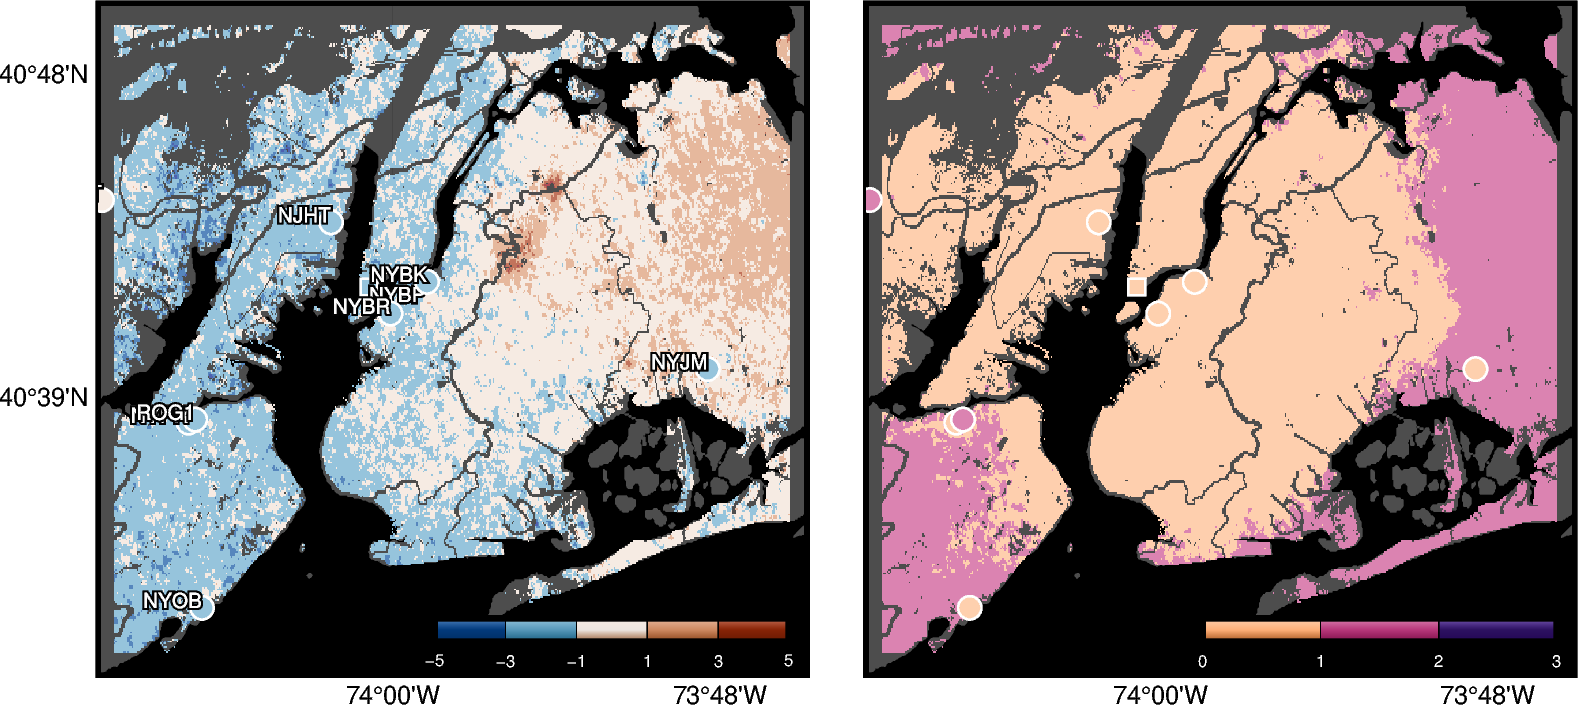

Wrote: /u/leffe-data2/buzzanga/data/VLM/Sentinel1/NYC_ARIA/NYBP_Base_Fast/Figs_Vup/Vup_Base_Fast_ARIA.png


In [117]:
PlotObj = plotGMT.PlotVLM(Exp.reg, Exp.path_mp_vup)

fig = PlotObj.plot_together_gps(rate, unc, df_gps, continuous=False)
fig.show(dpi=600, width=1000)
# fig.savefig(dst, dpi=300, anti_alias=True)

dst = op.join(Exp.path_mp_exp, 'Figs_Vup', f'{op.splitext(op.basename(Exp.path_vup_geo))[0]}.png')
os.makedirs(op.dirname(dst), exist_ok=True)
fig.savefig(dst, dpi=300, anti_alias=True)
print ('Wrote:', dst)

In [94]:
#### plot time series around a point
from VLM.bzFRInGE.contrib.plotting import plot_ts

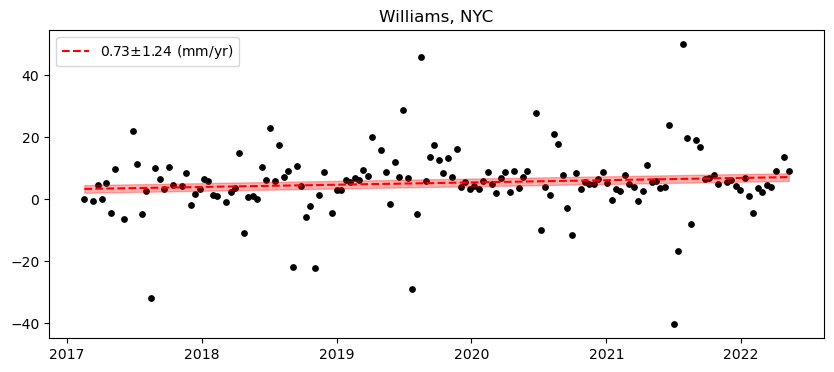

In [102]:
plot_ts.plot_ts_vup1(Exp, 'Williams', mask=False, rad=50)
# plot_ts_vup1(Exp, 'Williams')

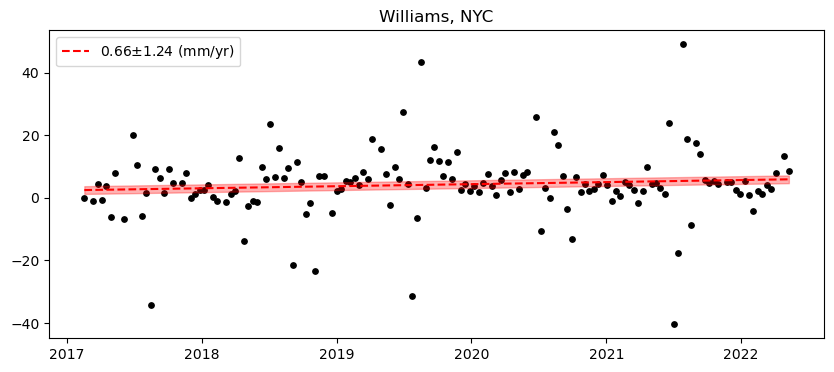

In [106]:
plot_ts.plot_ts_vup1(Exp, 'Williams', mask=False, rad=100)
# plot_ts_vup1(Exp, 'Williams')

## Misc

In [279]:
## convert geocoords to array coords
# mainly a check on rasterio
from mintpy.utils import readfile, utils as ut
# path_vel  = op.join(Exp.path_vup, f'velocity_{ts}_{exp}.h5')
# path_geom = op.join(Exp.path_mp, 'inputs', 'geometryGeo.h5') # doesnt matter which mintpy dir
            

# initiate coordinate object
atr = readfile.read_attribute(Exp.path_vup_geo)
coord = ut.coordinate(atr, lookup_file=path_mp_geom)
coord.open()

# lat/lon in degree --> row/col number (geo to radar)
lats   = [36.947, 36.822, 37.165, 36.967]
lons   = [-76.33, -76.293, -75.988, -76.113]
ys, xs = [], []
for lat, lon in zip(lats, lons):
    y, x     = coord.geo2radar(lat, lon)[0:2]
    print (f'input geo coordinate in (lat, lon): ({lat}, {lon})')
    print (f'corresponding radar coordinate in (y, x): ({y}, {x})')
    ys.append(y); xs.append(x)

input geo coordinate in (lat, lon): (36.947, -76.33)
corresponding radar coordinate in (y, x): (-4865, 4462)
input geo coordinate in (lat, lon): (36.822, -76.293)
corresponding radar coordinate in (y, x): (-4715, 4506)
input geo coordinate in (lat, lon): (37.165, -75.988)
corresponding radar coordinate in (y, x): (-5127, 4872)
input geo coordinate in (lat, lon): (36.967, -76.113)
corresponding radar coordinate in (y, x): (-4889, 4722)
